## Learning average SR

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

## Part 1: Learning N agents on different games

### DQN agent class

In [2]:
class DQNActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DQNAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.returns = []
        
        self.replay = config.replay_fn()
        self.actor = DQNActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.loss_vec = []

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
            
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        if self.total_steps > self.config.exploration_steps:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network(next_states).detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).long()
            q = self.network(states)
            q = q[self.batch_indices, actions]
            loss = (q_next - q).pow(2).mul(0.5).mean()
            self.loss_vec.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR agent class

In [3]:
import torch.nn as nn
class SRNet_backup(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, gate=F.relu):
        super(SRNet_backup, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        self.layer1 = layer_init(nn.Linear(body.feature_dim, body.feature_dim))
        self.layer2 = layer_init(nn.Linear(body.feature_dim, body.feature_dim))
        self.layer3 = layer_init(nn.Linear(body.feature_dim, body.feature_dim * output_dim))
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.w = Parameter(torch.Tensor(body.feature_dim))
        nn.init.constant_(self.w, 0) # CHECK for better initialization
        

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = self.gate(self.layer1(phi)) # shape: b x state_dim
        psi = self.gate(self.layer2(psi)) # shape: b x (state_dim)
        psi = self.gate(self.layer3(psi)) # shape: b x (state_dim*action_dim)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = torch.matmul(psi, self.w)

        return phi, psi, out

#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.

"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + config.c * loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Typical tricks
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### Sub function for DQN and DSR

In [4]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 10

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 3e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

### Code: Running N agents

In [5]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [35]:
def _visualize_vector(vector, title="unnamed", show_goal=False, show=True):
    """Function to visualize vector of size 104"""
    
    current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
    for i in range(104):
    #     if(vals[i]>0):
    #         import pdb; pdb.set_trace()
        p_cell = env.tocell[i]
        current_grid[p_cell[0], p_cell[1]] = vector[i]

        if show_goal:
            goal_cell = env.tocell[env.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -1
        
    plt.imshow(current_grid), plt.colorbar()
    plt.title(title)
    if show:
        plt.show()
    
def sanity(agent):
    # Setting things up
    env = FourRooms(goal=9)
    
    # Visualize state values
    statevals = list(range(104))
    _visualize_vector(statevals, title="state values")
    
    # Visualize w
    w_vector = agent2.network.state_dict()['w'].numpy()
    _visualize_vector(w_vector, title="w learnt values")
    
    # Visualize psi
    states = [0]
    plt.figure(figsize=(len(states)*18, 10))
    
    for i, s in enumerate(states):
        temp = np.zeros(len(env.obs_space))
        temp[s] = 1
        phi, psi, q = agent2.network(tensor(temp).unsqueeze(0))
        psi = psi.detach().numpy()
        q = q.detach().numpy().flatten()
        for na in range(4):
            plt.subplot(len(states), 4, i*4+na+1)
            _visualize_vector(psi[:,na,:].flatten(), title="q({},{})={}".format(i, na, q[na]), show=False)
            
    # Visualize policy
    state_space = np.identity(104)
    phi, psi, q = agent2.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy
    _visualize_vector(optimal_actions, title='policy')
    
    
    
    plt.show()
sanity(agent2)
    

NameError: name 'FourRooms' is not defined

In [36]:
%debug

> <ipython-input-35-4bde0b5e65db>(22)sanity()
     20 def sanity(agent):
     21     # Setting things up
---> 22     env = FourRooms(goal=9)
     23 
     24     # Visualize state values

ipdb> q


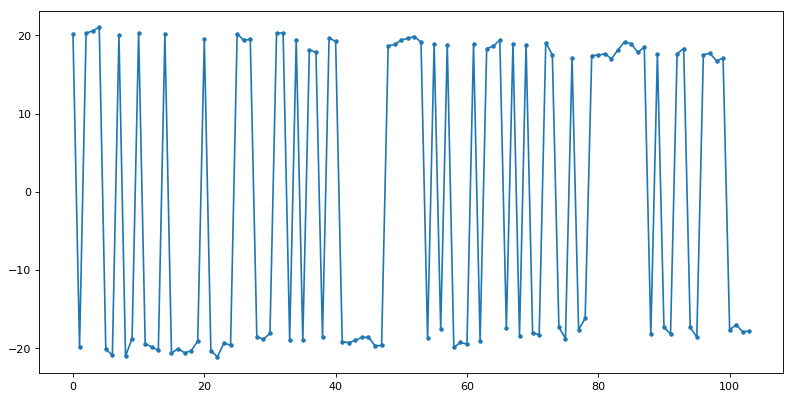

In [26]:
plt.figure(figsize=(12,6), dpi=80)
plt.plot(agent2.network.state_dict()['w'].numpy(), '.-')

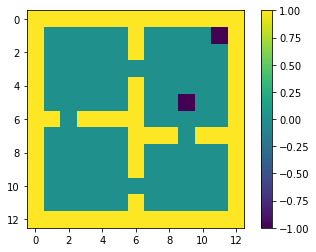

In [34]:
# from deep_rl.component.fourrooms import FourRooms
# env = FourRooms(goal=9)
state = env.reset()
plt.imshow(env.render())
plt.colorbar()

In [35]:
phi, psi, q = agent_k.network(tensor(state).unsqueeze(0))

In [36]:
psi.shape

torch.Size([1, 4, 104])

In [41]:
vals = psi[0,3,:].detach().numpy()
vals.shape
print(vals)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [106]:
vals = agent2.network.state_dict()['w'].numpy()

(<matplotlib.image.AxesImage at 0x7f246f407ac8>,
 <matplotlib.colorbar.Colorbar at 0x7f246f357518>)

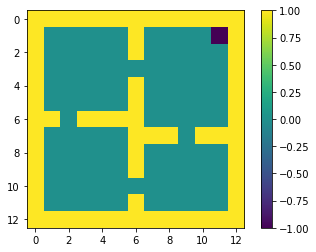

In [38]:
current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
for i in range(104):
#     if(vals[i]>0):
#         import pdb; pdb.set_trace()
    p_cell = env.tocell[i]
    current_grid[p_cell[0], p_cell[1]] = vals[i]

    if True:
        goal_cell = env.tocell[env.goal]
        current_grid[goal_cell[0], goal_cell[1]] = -1
        
plt.imshow(current_grid), plt.colorbar()

In [ ]:
len(storage[0][0][1])

3219
3425
3471
3314
3451
3407
3368
3300
3545
3555


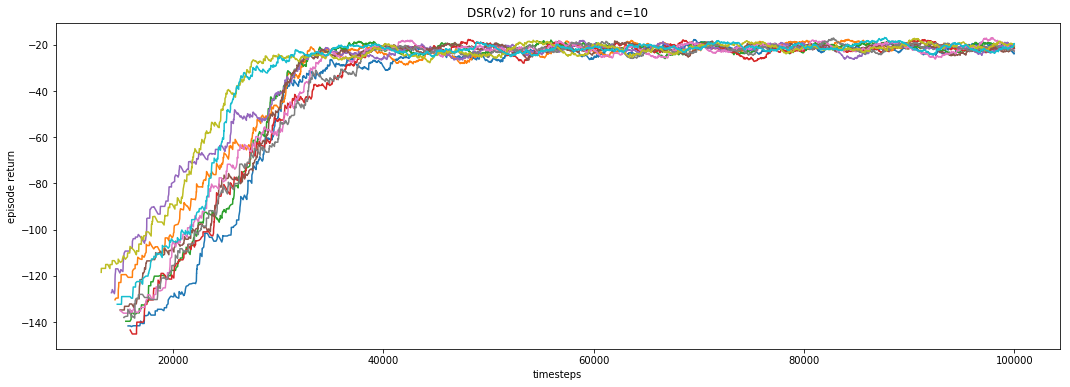

In [12]:
plt.figure(figsize=(18,6))
for i, s in enumerate(storage):
#     if(i < 9):
#         continue
    returns = s[0]
    print(len(returns))
    plt.plot(np.array(returns)[110:,0],convolve(np.array(returns)[:,1], kernelSize=111)/111)

plt.title('DSR(v2) for 10 runs and c=10')
plt.ylabel('episode return'), plt.xlabel('timesteps')
plt.show()

In [10]:
runs = 5
# storage = []
for run in range(runs):
    agent2 = dsr_feature(game='FourRooms-Goal-9')
    storage.append([agent2.returns, agent2.loss_vec, agent2.loss_q_vec, agent2.loss_psi_vec])

2020-04-09 21:39:56,830 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-09 21:40:04,378 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-09 21:40:12,840 - root - INFO: steps 10000, episodic_return_test -116.20(28.56)
2020-04-09 21:40:20,711 - root - INFO: steps 15000, episodic_return_test -84.90(29.74)
2020-04-09 21:40:30,203 - root - INFO: steps 20000, episodic_return_test -144.80(26.68)
2020-04-09 21:40:38,628 - root - INFO: steps 25000, episodic_return_test -85.20(29.69)
2020-04-09 21:40:49,061 - root - INFO: steps 30000, episodic_return_test -124.80(29.18)
2020-04-09 21:40:58,466 - root - INFO: steps 35000, episodic_return_test -142.40(27.83)
2020-04-09 21:41:07,185 - root - INFO: steps 40000, episodic_return_test -86.40(29.34)
2020-04-09 21:41:15,855 - root - INFO: steps 45000, episodic_return_test -33.50(17.77)
2020-04-09 21:41:25,258 - root - INFO: steps 50000, episodic_return_test -14.90(2.66)
2020-04-09 21:41:35,077 - root - INFO: steps 

2020-04-09 21:56:25,131 - root - INFO: steps 55000, episodic_return_test -15.60(2.68)
2020-04-09 21:56:37,712 - root - INFO: steps 60000, episodic_return_test -48.60(24.03)
2020-04-09 21:56:50,872 - root - INFO: steps 65000, episodic_return_test -16.20(2.24)
2020-04-09 21:57:02,514 - root - INFO: steps 70000, episodic_return_test -12.20(1.85)
2020-04-09 21:57:12,654 - root - INFO: steps 75000, episodic_return_test -12.40(2.75)
2020-04-09 21:57:24,809 - root - INFO: steps 80000, episodic_return_test -84.10(29.94)
2020-04-09 21:57:38,829 - root - INFO: steps 85000, episodic_return_test -73.10(26.47)
2020-04-09 21:57:52,580 - root - INFO: steps 90000, episodic_return_test -52.40(23.47)
2020-04-09 21:58:04,979 - root - INFO: steps 95000, episodic_return_test -75.60(25.86)
2020-04-09 21:58:16,619 - root - INFO: steps 100000, episodic_return_test -19.20(3.79)


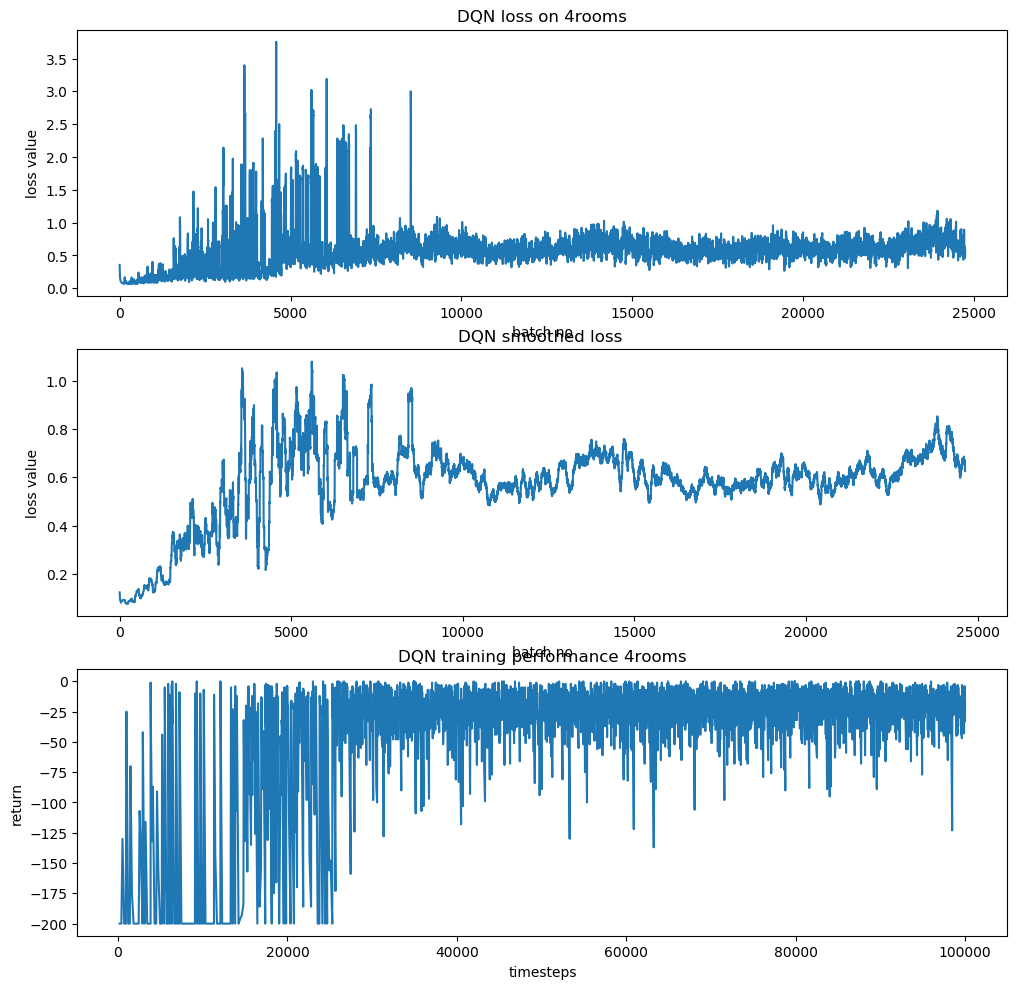

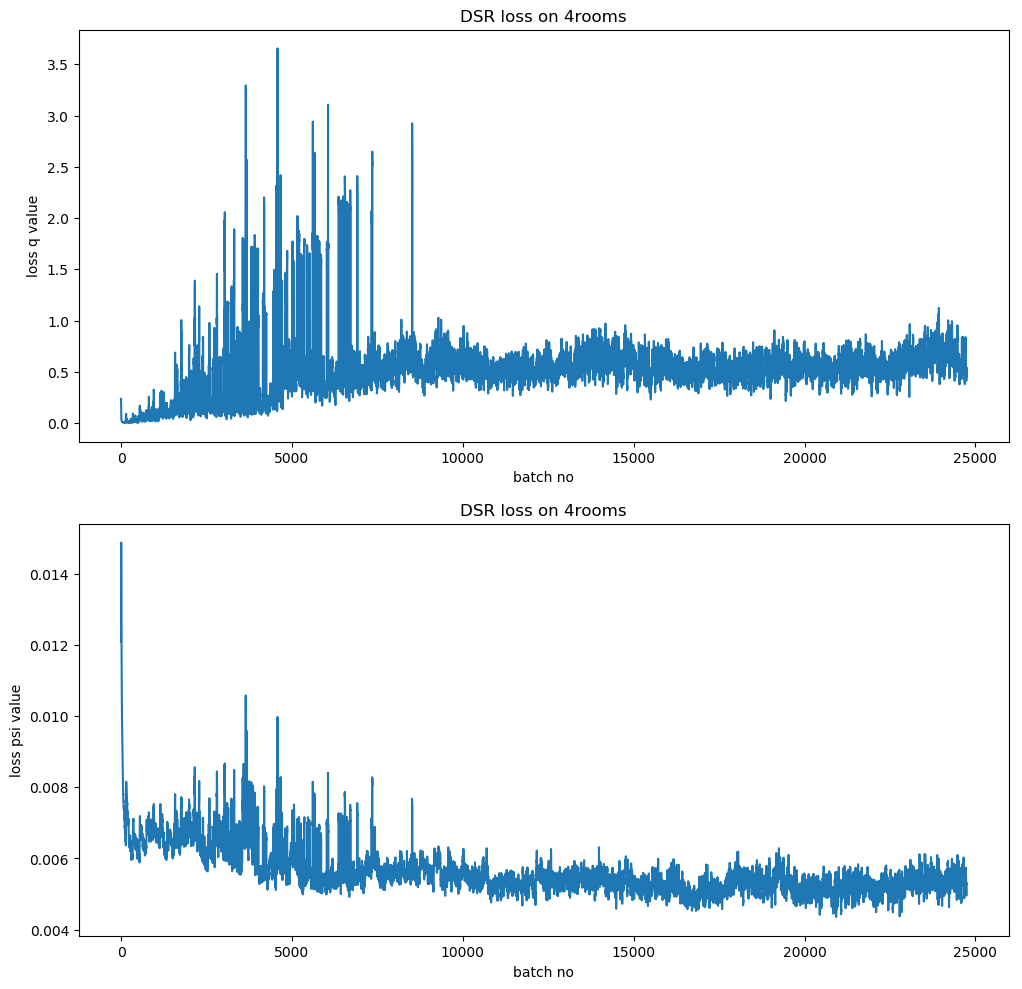

In [38]:
plot_dqn(agent2)
plot_dsr(agent2)

In [19]:
agent3 = dqn_feature(game='FourRooms-Goal-94')

2020-04-09 22:07:02,619 - root - INFO: steps 0, episodic_return_test -160.40(25.05)
2020-04-09 22:07:07,141 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-09 22:07:11,366 - root - INFO: steps 10000, episodic_return_test -161.20(24.54)
2020-04-09 22:07:15,606 - root - INFO: steps 15000, episodic_return_test -162.70(23.59)
2020-04-09 22:07:19,750 - root - INFO: steps 20000, episodic_return_test -105.00(30.13)
2020-04-09 22:07:23,866 - root - INFO: steps 25000, episodic_return_test -102.90(30.73)
2020-04-09 22:07:27,944 - root - INFO: steps 30000, episodic_return_test -22.80(5.60)


In [12]:
runs = 1
storage = []
for run in range(runs):
    agent2 = dsr_feature(game='FourRooms-Goal-9')
    storage.append([agent2.returns, agent2.loss_vec, agent2.loss_q_vec, agent2.loss_psi_vec])

2020-04-09 19:53:58,431 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-09 19:54:05,760 - root - INFO: steps 5000, episodic_return_test -180.50(18.50)
2020-04-09 19:54:14,473 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-09 19:54:22,618 - root - INFO: steps 15000, episodic_return_test -180.30(18.69)
2020-04-09 19:54:30,895 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-09 19:54:47,022 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-09 19:55:27,630 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-09 19:55:45,631 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-09 19:55:54,518 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-09 19:56:03,259 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-04-09 19:56:11,444 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
2020-04-09 19:56:19,639 - root - INFO: steps 5

In [58]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title('DQN training performance 4rooms')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
#     plt.subplot(211)
#     plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
#     plt.title(title+' loss on 4rooms')
#     plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss on 4rooms')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

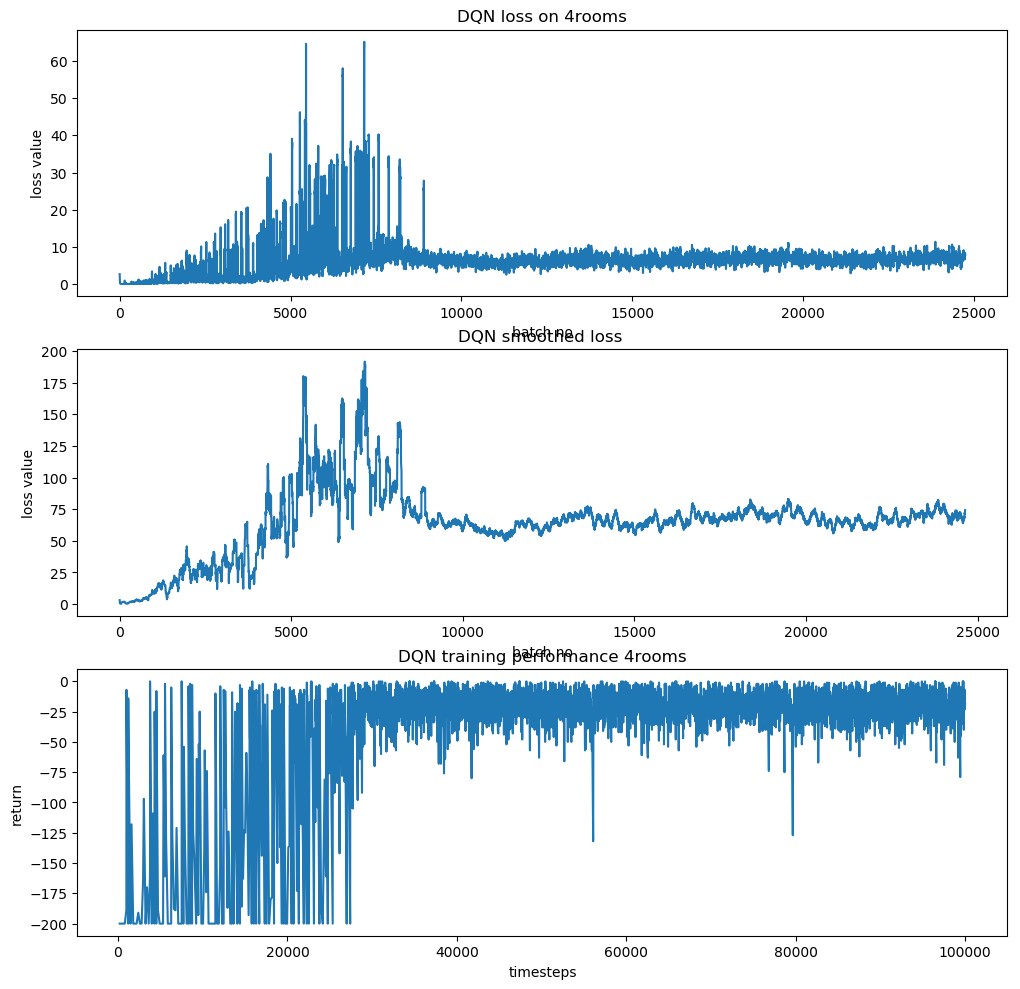

In [12]:
# plot_dqn(agent1)
# plot_dqn(agent2)
plot_dqn(agent3)

## Part 2: Learning an average SR agent (unsupervised)

### Class definition for average agent

In [53]:
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config

        # Choose one of the base agents randomly
        pick = random.choice(self.agents)

        # Find qvalues of the picked agent for the present state
        with config.lock:
            q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            _, psi_next, _ = self.network(next_states)
            psi_next = psi_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.network(states)[0]) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _ = self.network(states)
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_psi
            
            self.loss_vec.append(loss.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()


### Coding: avDSR

In [54]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

### Code to learn average agent

In [55]:
# agents = [agent1, agent2, agent3]
agents = [agent3]
agent_k = avDSR(game='FourRooms-Goal-9', agents=agents)

2020-04-10 00:27:48,804 - root - INFO: steps 0, 167772160.00 steps/s
2020-04-10 00:27:50,401 - root - INFO: steps 1000, 627.81 steps/s
2020-04-10 00:27:52,050 - root - INFO: steps 2000, 607.54 steps/s
2020-04-10 00:27:53,586 - root - INFO: steps 3000, 652.35 steps/s
2020-04-10 00:27:55,044 - root - INFO: steps 4000, 687.15 steps/s
2020-04-10 00:27:56,521 - root - INFO: steps 5000, 677.97 steps/s
2020-04-10 00:27:58,013 - root - INFO: steps 6000, 672.20 steps/s
2020-04-10 00:27:59,441 - root - INFO: steps 7000, 701.95 steps/s
2020-04-10 00:28:00,928 - root - INFO: steps 8000, 673.71 steps/s
2020-04-10 00:28:02,410 - root - INFO: steps 9000, 675.79 steps/s
2020-04-10 00:28:03,861 - root - INFO: steps 10000, 690.27 steps/s
2020-04-10 00:28:05,301 - root - INFO: steps 11000, 695.68 steps/s
2020-04-10 00:28:06,739 - root - INFO: steps 12000, 696.77 steps/s
2020-04-10 00:28:08,200 - root - INFO: steps 13000, 685.48 steps/s
2020-04-10 00:28:09,703 - root - INFO: steps 14000, 666.35 steps/s
20

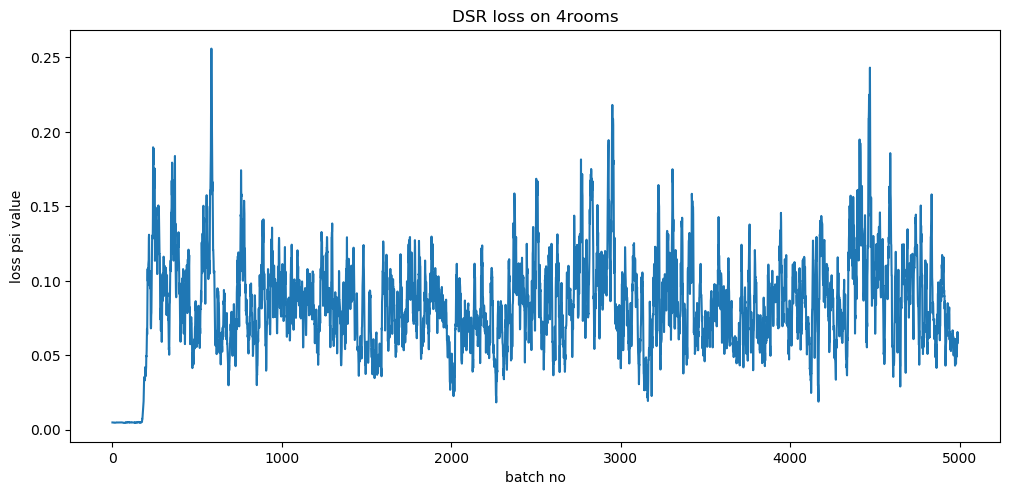

In [59]:
plot_dsr(agent_k)

In [60]:
agent_k.network.state_dict()# ensure w has only 0s. 

OrderedDict([('w',
              tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0., 0., 0., 0.])),
             ('layer1.weight',
              tensor([[ 0.0473,  0.0983, -0.0401,  ...,  0.0661,  0.0223, -0.0126],
                      [-0.1713,  0.0850,  0.0931,  ...,  0.0188, -0.0248,  0.0762],
                      [-0.0564,  0.0357,  0.0045,  ...,  0.1595,  0.0069,  0.0014],
                      ...,
                      [ 0.0497, -0.0592,  0.1233,  ...,  0.0793,  0.1848,  0.0684],
                      [-0.0058, -0.0761, -0.0358,  ...,  0

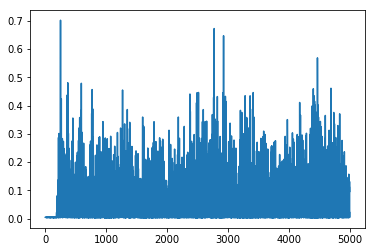

In [61]:
plt.plot(agent_k.loss_vec)

## Part 3: Learning agent initialized to avSR across good policies

In [62]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 4e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [118]:
r_vec_backup = r_vec
t_vec_backup = t_vec

In [63]:
r_vec = []; t_vec = []

from tqdm import trange, tqdm
for i in trange(1, desc='runs'): 
    agent_f = dsr_feature_init(ref=agent_k, game='FourRooms-Goal-103')
    rewards = np.array(agent_f.returns)
    r_vec.append(rewards[:,0])
    t_vec.append(rewards[:,1])
    

runs:   0%|          | 0/1 [00:00<?, ?it/s]2020-04-10 00:33:28,359 - root - INFO: steps 0, episodic_return_test -180.10(18.88)
2020-04-10 00:33:35,929 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-10 00:33:44,396 - root - INFO: steps 10000, episodic_return_test -180.40(18.59)
2020-04-10 00:33:52,560 - root - INFO: steps 15000, episodic_return_test -161.10(24.60)
2020-04-10 00:34:00,372 - root - INFO: steps 20000, episodic_return_test -123.90(29.50)
2020-04-10 00:34:08,003 - root - INFO: steps 25000, episodic_return_test -50.70(23.71)
2020-04-10 00:34:16,202 - root - INFO: steps 30000, episodic_return_test -181.30(17.74)
2020-04-10 00:34:26,631 - root - INFO: steps 35000, episodic_return_test -48.90(23.97)
2020-04-10 00:34:37,180 - root - INFO: steps 40000, episodic_return_test -28.60(18.18)
runs: 100%|██████████| 1/1 [01:09<00:00, 69.43s/it]


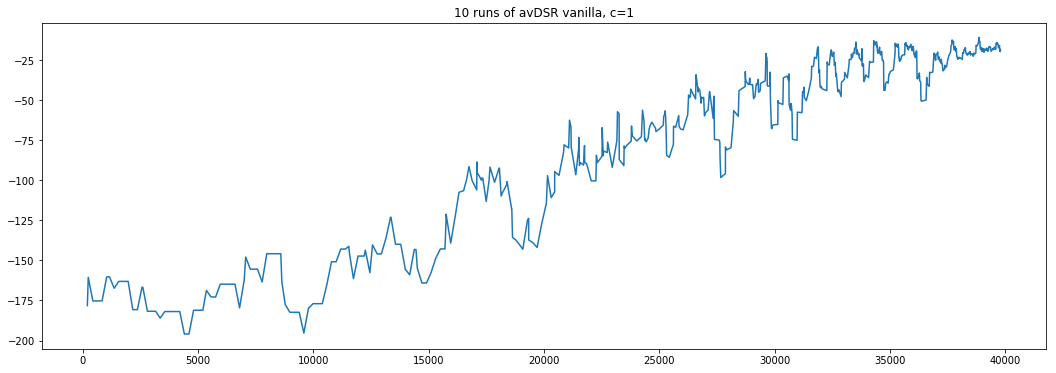

In [64]:
plt.figure(figsize=(18, 6))
for t, r in zip(r_vec, t_vec):
    plt.plot(t[:-10], convolve(r, kernelSize=11)/11)
    plt.title('10 runs of avDSR vanilla, c=' + str(agent_f.config.c))

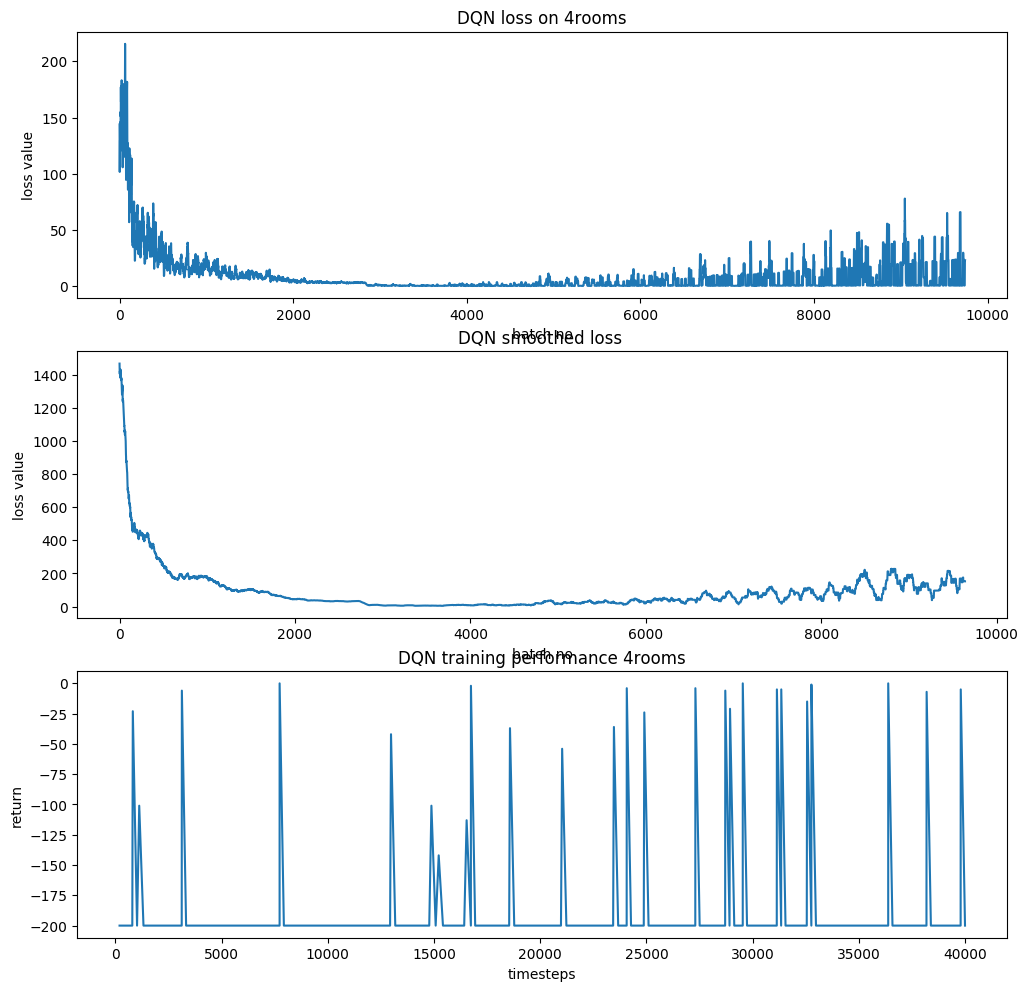

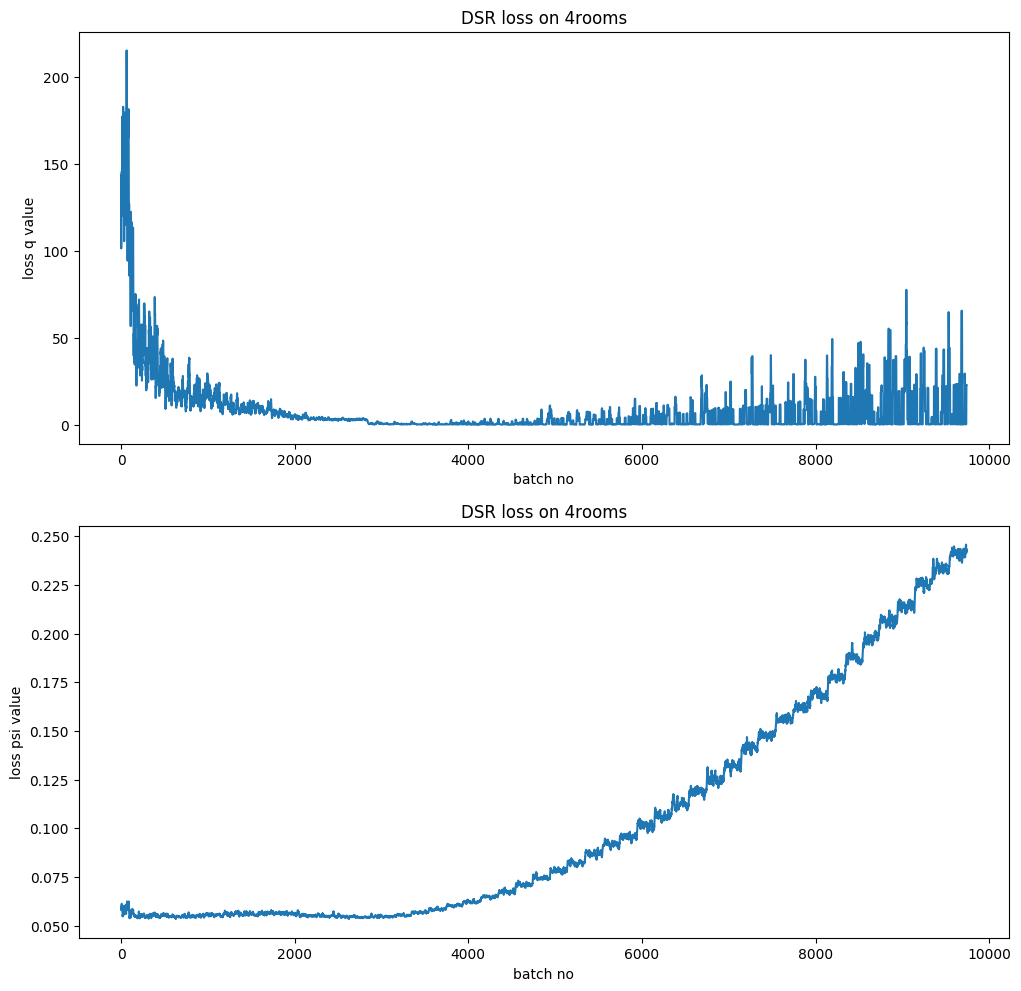

In [124]:
plot_dqn(agent_f)
plot_dsr(agent_f)

In [34]:
dqn_feature(game='FourRooms-Goal-94')

2020-04-03 04:00:22,424 - root - INFO: steps 0, episodic_return_test -162.30(23.88)
2020-04-03 04:00:26,184 - root - INFO: steps 5000, episodic_return_test -160.00(25.30)
2020-04-03 04:00:30,259 - root - INFO: steps 10000, episodic_return_test -142.20(27.93)
2020-04-03 04:00:34,276 - root - INFO: steps 15000, episodic_return_test -160.80(24.80)
2020-04-03 04:00:38,102 - root - INFO: steps 20000, episodic_return_test -50.50(23.72)
2020-04-03 04:00:42,004 - root - INFO: steps 25000, episodic_return_test -36.30(17.31)
2020-04-03 04:00:45,626 - root - INFO: steps 30000, episodic_return_test -14.70(2.79)
2020-04-03 04:00:49,692 - root - INFO: steps 35000, episodic_return_test -14.00(1.54)
2020-04-03 04:00:53,780 - root - INFO: steps 40000, episodic_return_test -13.30(3.19)
2020-04-03 04:00:57,819 - root - INFO: steps 45000, episodic_return_test -14.50(2.68)
2020-04-03 04:01:01,727 - root - INFO: steps 50000, episodic_return_test -18.20(3.36)
2020-04-03 04:01:05,546 - root - INFO: steps 5500

Process AsyncReplay-21:
Traceback (most recent call last):
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/network/home/penmetss/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [35]:
test = dqn_feature(game='FourRooms-Goal-103')

2020-04-03 04:01:45,473 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-03 04:01:48,924 - root - INFO: steps 5000, episodic_return_test -180.20(18.78)
2020-04-03 04:01:52,922 - root - INFO: steps 10000, episodic_return_test -160.80(24.80)
2020-04-03 04:01:57,036 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-03 04:02:00,927 - root - INFO: steps 20000, episodic_return_test -102.50(30.87)
2020-04-03 04:02:04,710 - root - INFO: steps 25000, episodic_return_test -104.80(30.13)
2020-04-03 04:02:08,313 - root - INFO: steps 30000, episodic_return_test -90.70(28.28)
2020-04-03 04:02:12,061 - root - INFO: steps 35000, episodic_return_test -14.20(1.44)
2020-04-03 04:02:15,726 - root - INFO: steps 40000, episodic_return_test -13.40(2.14)
2020-04-03 04:02:19,787 - root - INFO: steps 45000, episodic_return_test -18.40(3.12)
2020-04-03 04:02:23,529 - root - INFO: steps 50000, episodic_return_test -15.70(2.10)
2020-04-03 04:02:27,246 - root - INFO: steps 550

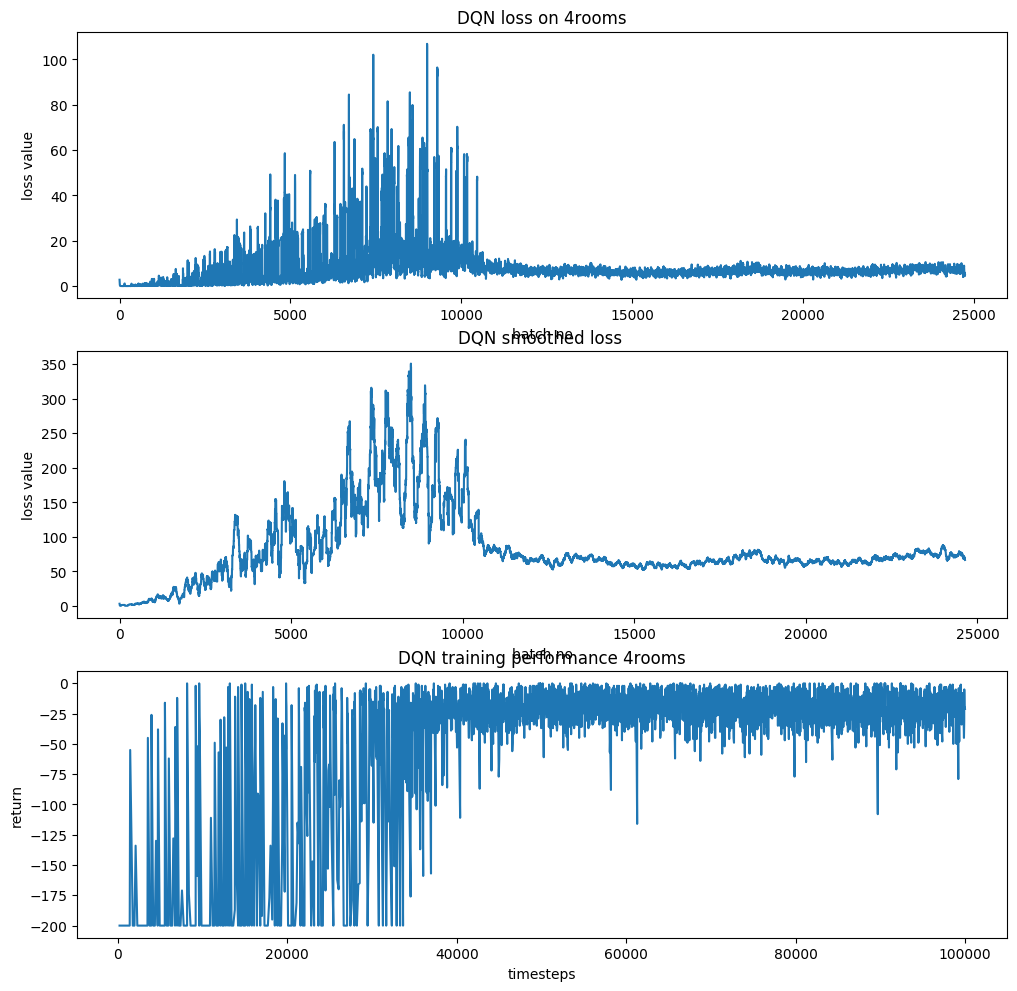

In [37]:
plot_dqn(test)